## Step 1: Load and Inspect Data

In [1]:

import pandas as pd

# Load Excel file
file_path = "Customer_Churn_Data_Large.xlsx"
excel_file = pd.ExcelFile(file_path)

# Load sheets
demographics_df = excel_file.parse('Customer_Demographics')
transactions_df = excel_file.parse('Transaction_History')
service_df = excel_file.parse('Customer_Service')
activity_df = excel_file.parse('Online_Activity')
churn_df = excel_file.parse('Churn_Status')

# Preview
print(demographics_df.head())
print(transactions_df.head())


   CustomerID  Age Gender MaritalStatus IncomeLevel
0           1   62      M        Single         Low
1           2   65      M       Married         Low
2           3   18      M        Single         Low
3           4   21      M       Widowed         Low
4           5   21      M      Divorced      Medium
   CustomerID  TransactionID TransactionDate  AmountSpent ProductCategory
0           1           7194      2022-03-27       416.50     Electronics
1           2           7250      2022-08-08        54.96        Clothing
2           2           9660      2022-07-25       197.50     Electronics
3           2           2998      2022-01-25       101.31       Furniture
4           2           1228      2022-07-24       397.37        Clothing


## Step 2: Merge All Datasets

In [2]:

merged_df = churn_df.merge(demographics_df, on='CustomerID', how='left')
merged_df = merged_df.merge(activity_df, on='CustomerID', how='left')
merged_df = merged_df.merge(service_df, on='CustomerID', how='left')
merged_df = merged_df.merge(transactions_df, on='CustomerID', how='left')

# Convert date columns
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])
merged_df['InteractionDate'] = pd.to_datetime(merged_df['InteractionDate'])
merged_df['LastLoginDate'] = pd.to_datetime(merged_df['LastLoginDate'])
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        6812 non-null   int64         
 1   ChurnStatus       6812 non-null   int64         
 2   Age               6812 non-null   int64         
 3   Gender            6812 non-null   object        
 4   MaritalStatus     6812 non-null   object        
 5   IncomeLevel       6812 non-null   object        
 6   LastLoginDate     6812 non-null   datetime64[ns]
 7   LoginFrequency    6812 non-null   int64         
 8   ServiceUsage      6812 non-null   object        
 9   InteractionID     5204 non-null   float64       
 10  InteractionDate   5204 non-null   datetime64[ns]
 11  InteractionType   5204 non-null   object        
 12  ResolutionStatus  5204 non-null   object        
 13  TransactionID     6812 non-null   int64         
 14  TransactionDate   6812 n

## Step 3: Data Cleaning

In [3]:

merged_df['InteractionType'] = merged_df['InteractionType'].fillna('No Interaction')
merged_df['ResolutionStatus'] = merged_df['ResolutionStatus'].fillna('None')
merged_df['InteractionID'] = merged_df['InteractionID'].fillna(0)
merged_df['InteractionDate'] = merged_df['InteractionDate'].fillna(pd.Timestamp('1900-01-01'))


## Step 4: Encoding and Normalization

In [4]:

from sklearn.preprocessing import StandardScaler

# Encode categorical
encoded_df = pd.get_dummies(merged_df, columns=[
    'Gender', 'MaritalStatus', 'IncomeLevel', 'ServiceUsage',
    'InteractionType', 'ResolutionStatus', 'ProductCategory'
], drop_first=True)

# Normalize numeric
scaler = StandardScaler()
encoded_df[['Age', 'LoginFrequency', 'AmountSpent']] = scaler.fit_transform(
    encoded_df[['Age', 'LoginFrequency', 'AmountSpent']]
)

# Drop unused columns
cleaned_df = encoded_df.drop(columns=['CustomerID', 'TransactionID', 'TransactionDate', 'InteractionID', 'InteractionDate', 'LastLoginDate'])
cleaned_df.head()


,ChurnStatus,Age,LoginFrequency,AmountSpent,Gender_M,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_Low,IncomeLevel_Medium,...,ServiceUsage_Website,InteractionType_Feedback,InteractionType_Inquiry,InteractionType_No Interaction,ResolutionStatus_Resolved,ResolutionStatus_Unresolved,ProductCategory_Clothing,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Groceries
0,0,1.225036,0.588556,1.153881,True,False,True,False,True,False,...,False,False,True,False,True,False,False,True,False,False
1,1,1.421298,-1.473886,-1.376296,True,True,False,False,True,False,...,True,False,True,False,True,False,True,False,False,False
2,1,1.421298,-1.473886,-0.378753,True,True,False,False,True,False,...,True,False,True,False,True,False,False,True,False,False
3,1,1.421298,-1.473886,-1.051923,True,True,False,False,True,False,...,True,False,True,False,True,False,False,False,True,False
4,1,1.421298,-1.473886,1.020003,True,True,False,False,True,False,...,True,False,True,False,True,False,True,False,False,False


## Step 5: Exploratory Data Analysis

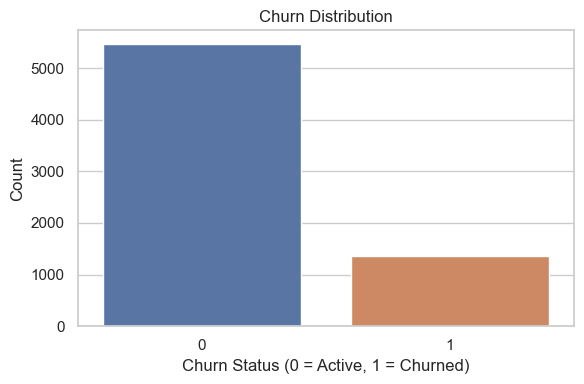

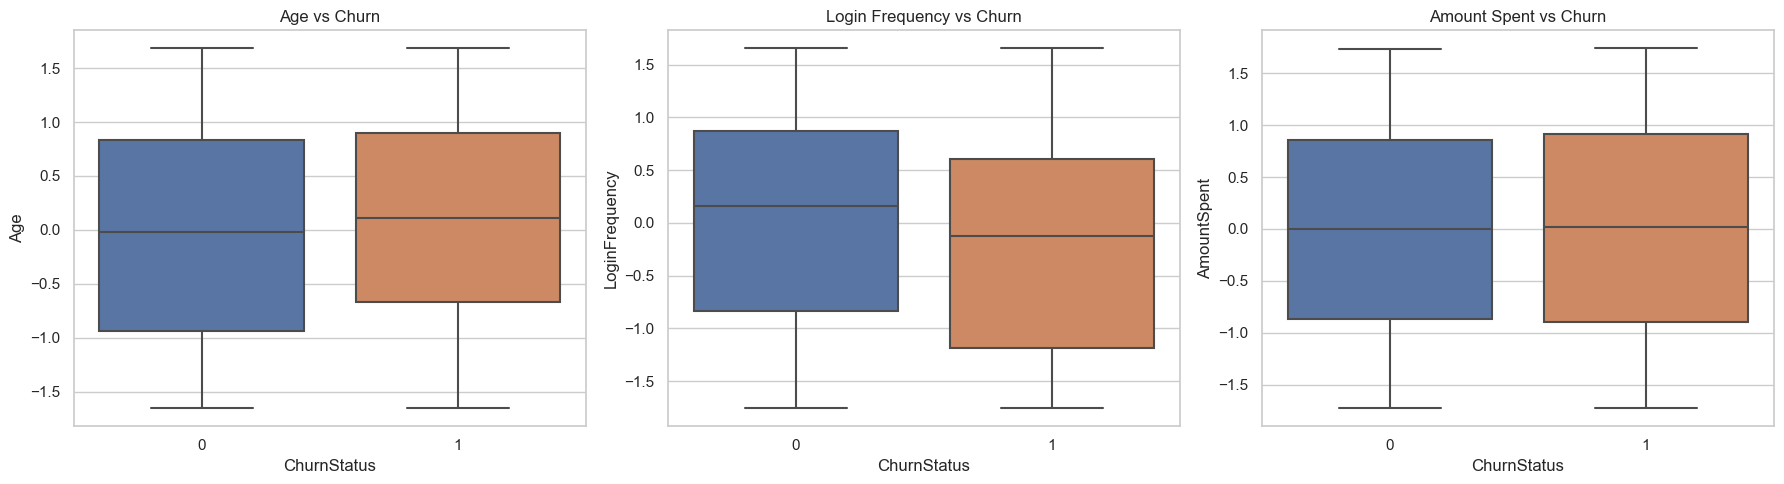

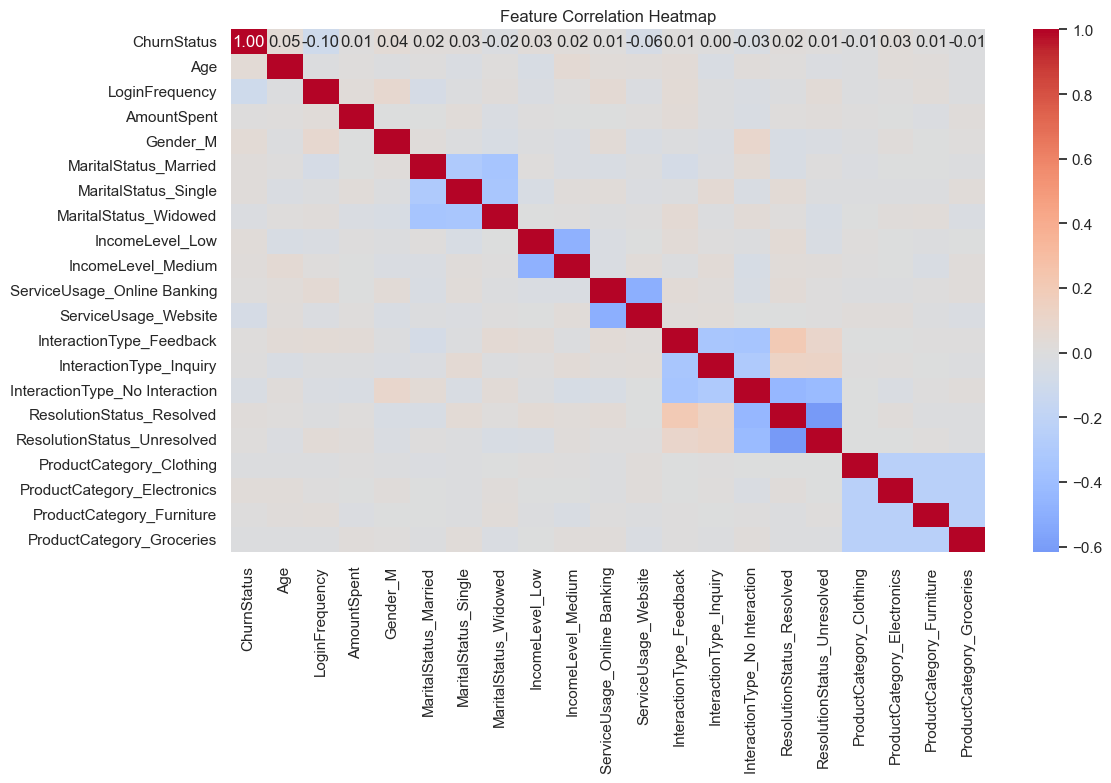

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Churn count
plt.figure(figsize=(6, 4))
sns.countplot(data=cleaned_df, x='ChurnStatus')
plt.title('Churn Distribution')
plt.xlabel('Churn Status (0 = Active, 1 = Churned)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Box plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(data=cleaned_df, x='ChurnStatus', y='Age', ax=axes[0])
sns.boxplot(data=cleaned_df, x='ChurnStatus', y='LoginFrequency', ax=axes[1])
sns.boxplot(data=cleaned_df, x='ChurnStatus', y='AmountSpent', ax=axes[2])
axes[0].set_title('Age vs Churn')
axes[1].set_title('Login Frequency vs Churn')
axes[2].set_title('Amount Spent vs Churn')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation = cleaned_df.corr()
sns.heatmap(correlation, cmap='coolwarm', annot=True, fmt='.2f', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()
